In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bayyin-dataset/bayyin_dataset.csv
/kaggle/input/arabert-embbdings/train_test_split (1).pkl


In [13]:
pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
Note: you may need to restart the kernel to use updated packages.


In [14]:
import os
import re
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch.utils.data import TensorDataset, DataLoader


nltk.download('punkt')
nltk.download('punkt_tab')

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
warnings.filterwarnings("ignore")

Using device: cuda:0


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**Preprocessing**

In [15]:
CSV_PATH = '/kaggle/input/bayyin-dataset/bayyin_dataset.csv'
ARABERT_PKL_PATH = '/kaggle/input/arabert-embbdings/train_test_split (1).pkl'

ARABIC_DIACRITICS = re.compile(r'[\u064B-\u0652]')

def remove_diacritics(text):
    return ARABIC_DIACRITICS.sub('', text)

def remove_non_alpha(text):
    return re.sub(r'[^\w\s]', '', text)

def clean_text(text):
    if pd.isna(text) or not text:
        return ""
    text = str(text).lower()
    text = remove_diacritics(text)
    text = remove_non_alpha(text)
    return re.sub(r'\s+', ' ', text).strip()

def calculate_morph_complexity(tokens_col):
    if pd.isna(tokens_col) or not tokens_col:
        return 1.0
    original_words = tokens_col.split()
    total_morph_units = 0
    total_words = 0
    for word in original_words:
        morph_units = word.count('+') + 1
        total_morph_units += morph_units
        total_words += 1
    return total_morph_units / total_words if total_words > 0 else 1.0

try:
    df = pd.read_csv(CSV_PATH)
    
    # Data Cleaning
    df.dropna(subset=['Sentence', 'Lex', 'Word_Count', 'Readability_Level'], inplace=True)

    # Encode Target
    target_le = LabelEncoder()
    df['Readability_Level_Encoded'] = target_le.fit_transform(df['Readability_Level'])
    
    # Clean Text Column
    df['Clean_Lex'] = df['Lex'].apply(clean_text)
    
except FileNotFoundError:
    print(f"CRITICAL ERROR: CSV file not found at {CSV_PATH}")
    raise

**Feature Engineering**

In [16]:
# --- A. Statistical Features ---
df['Word_Count'] = df['Word_Count'].astype(int)
df['Avg_Lex_Length'] = df['Clean_Lex'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x else 0)
df['Lexical_Density'] = df['Clean_Lex'].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
df['Morph_Complexity'] = df['D3Tok'].apply(calculate_morph_complexity)

X_stats = df[['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']].values.astype(np.float64)

# Scale Statistical Features 
scaler = StandardScaler()
X_stats_scaled = scaler.fit_transform(X_stats)

# --- B. TF-IDF Features ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Clean_Lex'])

# --- C. Word2Vec Features ---
tokenized_sentences = [word_tokenize(text) for text in df['Sentence'].astype(str)]
w2v_model = Word2Vec(sentences=tokenized_sentences, vector_size=300, window=5, min_count=2, workers=4, sg=1)

def get_avg_vector(tokens, model, vector_size=300):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0: return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

X_w2v = np.array([get_avg_vector(tokens, w2v_model, 300) for tokens in tokenized_sentences])

# --- D. Combine Datasets ---
# Dataset 1: TF-IDF + Stats (Convert sparse TF-IDF to dense for GNN)
X_tfidf_stats = hstack([X_stats_scaled, tfidf_matrix]).toarray()

# Dataset 2: Word2Vec + Stats
X_w2v_stats = np.hstack([X_stats_scaled, X_w2v])

# Labels
y_labels = df['Readability_Level_Encoded'].values

print(f"TF-IDF+Stats Shape: {X_tfidf_stats.shape}")
print(f"Word2Vec+Stats Shape: {X_w2v_stats.shape}")

TF-IDF+Stats Shape: (46410, 5004)
Word2Vec+Stats Shape: (46410, 304)


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNReadability1D(nn.Module):
    def __init__(self, input_dim, num_classes=6, dropout=0.3):
        super(CNNReadability1D, self).__init__()
        
        # Convolutional blocks over 1D feature sequence
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        # Global pooling to get a single vector per sample
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        x shape: [N, input_dim]
        Treat features as a 1D sequence
        """
        x = x.unsqueeze(1)              # [N, 1, input_dim]
        
        x = self.conv1(x)               # [N, 128, L]
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)               # [N, 256, L]
        x = self.bn2(x)
        x = F.elu(x)
        x = self.dropout(x)
        
        x = self.conv3(x)               # [N, 256, L]
        x = F.elu(x)
        
        x = self.global_pool(x)         # [N, 256, 1]
        x = x.squeeze(-1)               # [N, 256]
        
        x = self.fc1(x)                 # [N, 128]
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)                 # [N, num_classes]
        return x

In [18]:
def run_cnn_experiment(X_features, y_targets, exp_name, batch_size=64):
    print(f"\n{exp_name} ")
    
    # 1. Dimensionality reduction (same condition as GNN)
    if X_features.shape[1] > 1000:
        print(f"Reducing dimensions from {X_features.shape[1]} to 300 using SVD")
        svd = TruncatedSVD(n_components=300, random_state=42)
        X_features = svd.fit_transform(X_features)
        print(f"New Feature Shape: {X_features.shape}")
        print(f"Explained Variance: {svd.explained_variance_ratio_.sum():.2%}")
    
    # 2. Train / Val / Test split (70% / 10% / 20%)
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_features, y_targets, test_size=0.2, random_state=42, stratify=y_targets
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.125, random_state=42, stratify=y_train_full
    )
    
    print(f"Data Splits: Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # 3. Build datasets and dataloaders (keep tensors on CPU, move per batch)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    
    X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
    
    X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.long)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 4. Initialize model, optimizer, and loss function
    input_dim = X_features.shape[1]
    model = CNNReadability1D(input_dim=input_dim, num_classes=6, dropout=0.3).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    # 5. Training loop with early stopping based on validation accuracy
    best_val_acc = 0
    patience = 15
    patience_counter = 0
    
    safe_name = exp_name.replace(" ", "").replace("+", "_")
    best_model_path = f'best_cnn_{safe_name}.pt'
    
    for epoch in range(50):
        model.train()
        epoch_loss = 0.0
        
        # Train over mini-batches 
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            
            optimizer.zero_grad()
            out = model(xb)               # [batch_size, num_classes]
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * xb.size(0)
        
        epoch_loss /= len(train_dataset)
        
        # Validation loop 
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                
                out_val = model(xb)
                pred_val = out_val.argmax(dim=1)
                correct += (pred_val == yb).sum().item()
                total += yb.size(0)
        
        acc_val = correct / total
        print(f"Epoch {epoch+1:02d} | Loss: {epoch_loss:.4f} | Val Acc: {acc_val:.4f}")
        
        # Save best model based on validation accuracy
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            patience_counter += 1
        
        # Early stopping if no improvement for several epochs
        if patience_counter >= patience:
            print(f"    Early stopping at Epoch {epoch+1}")
            break
    
    # 6. Evaluation on the test set
    print("Evaluating Best CNN Model")
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    
    all_true = []
    all_pred = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            
            out_test = model(xb)
            pred_test = out_test.argmax(dim=1)
            
            all_true.append(yb.cpu().numpy())
            all_pred.append(pred_test.cpu().numpy())
    
    y_true_test = np.concatenate(all_true)
    y_pred_test = np.concatenate(all_pred)
    
    # Compute metrics: accuracy, QWK, and ±1 accuracy
    test_acc = (y_pred_test == y_true_test).sum() / len(y_true_test)
    qwk = calculate_qwk(y_true_test, y_pred_test)
    adj = calculate_adjacency_accuracy(y_true_test, y_pred_test)
    
    print(f"\nResults: {exp_name}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"QWK Score:     {qwk:.4f}")
    print(f"±1 Accuracy:   {adj:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true_test, y_pred_test, digits=4))
    
    # Confusion matrix and normalized version
    cm = confusion_matrix(y_true_test, y_pred_test)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 5))
    class_labels = [1, 2, 3, 4, 5, 6]
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title(f'Confusion Matrix (CNN): {exp_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [19]:
def run_cnn_experiment(X_features, y_targets, exp_name, batch_size=64):
    print(f"\n{exp_name} ")
    
    # 1. Dimensionality reduction 
    if X_features.shape[1] > 1000:
        print(f"Reducing dimensions from {X_features.shape[1]} to 300 using SVD")
        svd = TruncatedSVD(n_components=300, random_state=42)
        X_features = svd.fit_transform(X_features)
        print(f"New Feature Shape: {X_features.shape}")
        print(f"Explained Variance: {svd.explained_variance_ratio_.sum():.2%}")
    
    # 2. Train / Val / Test split (70% / 10% / 20%)
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_features, y_targets, test_size=0.2, random_state=42, stratify=y_targets
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.125, random_state=42, stratify=y_train_full
    )
    
    print(f"Data Splits: Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # 3. Build datasets and dataloaders (keep tensors on CPU, move per batch)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    
    X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
    
    X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.long)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 4. Initialize model, optimizer, and loss function
    input_dim = X_features.shape[1]
    model = CNNReadability1D(input_dim=input_dim, num_classes=6, dropout=0.3).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    # 5. Training loop with early stopping based on validation accuracy
    best_val_acc = 0
    patience = 15
    patience_counter = 0
    
    safe_name = exp_name.replace(" ", "").replace("+", "_")
    best_model_path = f'best_cnn_{safe_name}.pt'
    
    for epoch in range(50):
        model.train()
        epoch_loss = 0.0
        
        # Train over mini-batches 
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            
            optimizer.zero_grad()
            out = model(xb)               # [batch_size, num_classes]
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * xb.size(0)
        
        epoch_loss /= len(train_dataset)
        
        # Validation loop 
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                
                out_val = model(xb)
                pred_val = out_val.argmax(dim=1)
                correct += (pred_val == yb).sum().item()
                total += yb.size(0)
        
        acc_val = correct / total
        print(f"Epoch {epoch+1:02d} | Loss: {epoch_loss:.4f} | Val Acc: {acc_val:.4f}")
        
        # Save best model based on validation accuracy
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            patience_counter += 1
        
        # Early stopping if no improvement for several epochs
        if patience_counter >= patience:
            print(f"    Early stopping at Epoch {epoch+1}")
            break
    
    # 6. Evaluation on the test set
    print("Evaluating Best CNN Model")
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    
    all_true = []
    all_pred = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            
            out_test = model(xb)
            pred_test = out_test.argmax(dim=1)
            
            all_true.append(yb.cpu().numpy())
            all_pred.append(pred_test.cpu().numpy())
    
    y_true_test = np.concatenate(all_true)
    y_pred_test = np.concatenate(all_pred)
    
    # Compute metrics: accuracy, QWK, and ±1 accuracy (inline, no helper functions)
    test_acc = (y_pred_test == y_true_test).sum() / len(y_true_test)
    qwk = cohen_kappa_score(y_true_test, y_pred_test, weights='quadratic')
    adj = np.sum(np.abs(y_true_test - y_pred_test) <= 1) / len(y_true_test)
    
    print(f"\nResults: {exp_name}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"QWK Score:     {qwk:.4f}")
    print(f"±1 Accuracy:   {adj:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true_test, y_pred_test, digits=4))
    
    # Confusion matrix and normalized version
    cm = confusion_matrix(y_true_test, y_pred_test)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 5))
    class_labels = [1, 2, 3, 4, 5, 6]
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title(f'Confusion Matrix (CNN): {exp_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


TF-IDF + Stats 
Reducing dimensions from 5004 to 300 using SVD
New Feature Shape: (46410, 300)
Explained Variance: 86.73%
Data Splits: Train: 32487, Val: 4641, Test: 9282
Epoch 01 | Loss: 1.5361 | Val Acc: 0.3581
Epoch 02 | Loss: 1.4827 | Val Acc: 0.3850
Epoch 03 | Loss: 1.4706 | Val Acc: 0.3896
Epoch 04 | Loss: 1.4630 | Val Acc: 0.3911
Epoch 05 | Loss: 1.4610 | Val Acc: 0.3652
Epoch 06 | Loss: 1.4538 | Val Acc: 0.3904
Epoch 07 | Loss: 1.4537 | Val Acc: 0.3978
Epoch 08 | Loss: 1.4503 | Val Acc: 0.3846
Epoch 09 | Loss: 1.4498 | Val Acc: 0.4014
Epoch 10 | Loss: 1.4498 | Val Acc: 0.3973
Epoch 11 | Loss: 1.4460 | Val Acc: 0.3844
Epoch 12 | Loss: 1.4404 | Val Acc: 0.3919
Epoch 13 | Loss: 1.4446 | Val Acc: 0.3993
Epoch 14 | Loss: 1.4391 | Val Acc: 0.3934
Epoch 15 | Loss: 1.4370 | Val Acc: 0.4038
Epoch 16 | Loss: 1.4364 | Val Acc: 0.3993
Epoch 17 | Loss: 1.4359 | Val Acc: 0.4057
Epoch 18 | Loss: 1.4355 | Val Acc: 0.4066
Epoch 19 | Loss: 1.4324 | Val Acc: 0.4085
Epoch 20 | Loss: 1.4330 | Val 

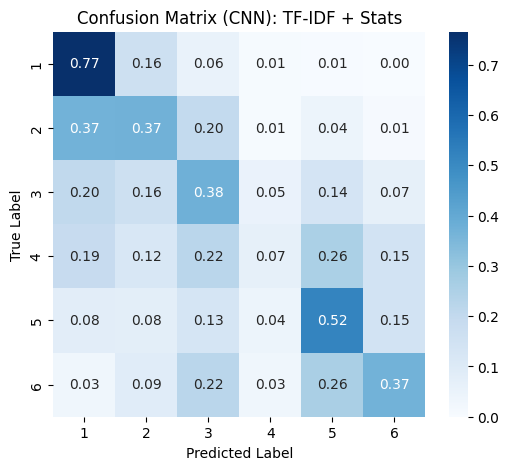

In [20]:
# TF-IDF + Stats
run_cnn_experiment(X_tfidf_stats, y_labels, "TF-IDF + Stats")

**Word2Vec + Stats model**


Word2Vec + Stats 
Data Splits: Train: 32487, Val: 4641, Test: 9282
Epoch 01 | Loss: 1.5467 | Val Acc: 0.3678
Epoch 02 | Loss: 1.4671 | Val Acc: 0.3833
Epoch 03 | Loss: 1.4447 | Val Acc: 0.4094
Epoch 04 | Loss: 1.4345 | Val Acc: 0.4057
Epoch 05 | Loss: 1.4253 | Val Acc: 0.4217
Epoch 06 | Loss: 1.4173 | Val Acc: 0.4191
Epoch 07 | Loss: 1.4121 | Val Acc: 0.4113
Epoch 08 | Loss: 1.4079 | Val Acc: 0.4223
Epoch 09 | Loss: 1.4086 | Val Acc: 0.4187
Epoch 10 | Loss: 1.4002 | Val Acc: 0.4324
Epoch 11 | Loss: 1.3973 | Val Acc: 0.4320
Epoch 12 | Loss: 1.3979 | Val Acc: 0.4312
Epoch 13 | Loss: 1.3936 | Val Acc: 0.4288
Epoch 14 | Loss: 1.3904 | Val Acc: 0.4430
Epoch 15 | Loss: 1.3880 | Val Acc: 0.4441
Epoch 16 | Loss: 1.3885 | Val Acc: 0.4376
Epoch 17 | Loss: 1.3818 | Val Acc: 0.4337
Epoch 18 | Loss: 1.3814 | Val Acc: 0.4365
Epoch 19 | Loss: 1.3816 | Val Acc: 0.4355
Epoch 20 | Loss: 1.3834 | Val Acc: 0.4490
Epoch 21 | Loss: 1.3755 | Val Acc: 0.4480
Epoch 22 | Loss: 1.3719 | Val Acc: 0.4400
Epoch 23

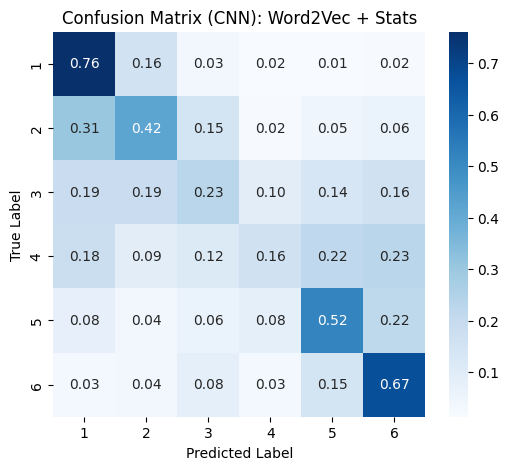

In [21]:
# Word2Vec + Stats 
run_cnn_experiment(X_w2v_stats, y_labels, "Word2Vec + Stats")

**AraBERT Embeddings model**


AraBERT Embeddings 
Data Splits: Train: 32487, Val: 4641, Test: 9282
Epoch 01 | Loss: 1.5726 | Val Acc: 0.3374
Epoch 02 | Loss: 1.5054 | Val Acc: 0.3323
Epoch 03 | Loss: 1.4718 | Val Acc: 0.3579
Epoch 04 | Loss: 1.4586 | Val Acc: 0.3835
Epoch 05 | Loss: 1.4401 | Val Acc: 0.3885
Epoch 06 | Loss: 1.4207 | Val Acc: 0.4103
Epoch 07 | Loss: 1.4106 | Val Acc: 0.4458
Epoch 08 | Loss: 1.3943 | Val Acc: 0.4594
Epoch 09 | Loss: 1.3794 | Val Acc: 0.4523
Epoch 10 | Loss: 1.3764 | Val Acc: 0.4702
Epoch 11 | Loss: 1.3714 | Val Acc: 0.4482
Epoch 12 | Loss: 1.3668 | Val Acc: 0.4618
Epoch 13 | Loss: 1.3628 | Val Acc: 0.4678
Epoch 14 | Loss: 1.3655 | Val Acc: 0.4779
Epoch 15 | Loss: 1.3555 | Val Acc: 0.4652
Epoch 16 | Loss: 1.3521 | Val Acc: 0.4768
Epoch 17 | Loss: 1.3503 | Val Acc: 0.4771
Epoch 18 | Loss: 1.3474 | Val Acc: 0.4801
Epoch 19 | Loss: 1.3522 | Val Acc: 0.4499
Epoch 20 | Loss: 1.3450 | Val Acc: 0.4697
Epoch 21 | Loss: 1.3444 | Val Acc: 0.4788
Epoch 22 | Loss: 1.3413 | Val Acc: 0.4820
Epoch 

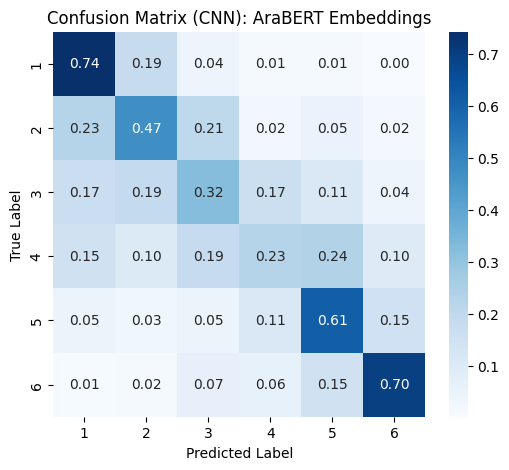

In [22]:
# AraBERT Embeddings

loaded_data = joblib.load(ARABERT_PKL_PATH)

# Handle possible formats from the loaded pickle
if isinstance(loaded_data, tuple):
    if len(loaded_data) == 4:
         X_train_ara, X_test_ara, y_train_ara, y_test_ara = loaded_data
    elif len(loaded_data) == 2:
         (X_train_ara, y_train_ara), (X_test_ara, y_test_ara) = loaded_data
elif isinstance(loaded_data, dict):
    X_train_ara = loaded_data.get('train_embeddings') or loaded_data.get('X_train')
    y_train_ara = loaded_data.get('train_labels') or loaded_data.get('y_train')
    X_test_ara = loaded_data.get('test_embeddings') or loaded_data.get('X_test')
    y_test_ara = loaded_data.get('test_labels') or loaded_data.get('y_test')

# Recombine for uniform GNN splitting
X_arabert_full = np.vstack((X_train_ara, X_test_ara))
y_arabert_full = np.concatenate((y_train_ara, y_test_ara))

# Run Experiment
run_cnn_experiment(X_arabert_full, y_arabert_full, "AraBERT Embeddings")